# Predict and Rebalance Portfolio
This workbook will predict the next days opening prices and rebalance the portfolio accordingly.
## Environment Setup

In [1]:
# Import packages

# General Utility
from datetime import datetime
import datetime, time
from datetime import timedelta

# Data processing
import numpy as np
import pandas as pd
import pickle

# Plotting
import matplotlib.pyplot as plt

# Neural Networks
import torch

# Diamond-Hands
import sys
sys.path.append('../Packages/')
import diamond_hands as dh

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ntnay\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
#Date
today = '2021-05-11'
today_formatted = '05_11_2021'

# Stocks
stocks = ['SPY','AAPL','AMC','BB','F','GME','GRWG','MO','NIO','PLTR','RKT','SNDL','TLRY','TSLA','VIAC']

# Keys
# Live
ALPACA_API_KEY = ''
ALPACA_SECRET_KEY = ''
FRED_API_KEY =''

# Data Locations
processed_input_dir = '../../Data/ProcessedInputs/'
prediction_input_dir = '../../Data/PredictionInputs/'
model_dir = '../../Data/Models/'
prediction_plot_dir = '../../Data/Outputs/Predictions/'
performance_plot_dir = '../../Data/Outputs/Performance/'
final_model_dir = '../../Data/Models/Final/'

# Comment Files
today_all = processed_input_dir+'Today_All_Comment_Summary.bin'
today_tickr = processed_input_dir+'Today_Tickr_Comment_Summary.bin'
tomorrow_all = processed_input_dir+'Tomorrow_All_Comment_Summary.bin'
tomorrow_tickr = processed_input_dir+'Tomorrow_Tickr_Comment_Summary.bin'

## Create Classes to aid the process

In [3]:
dl = dh.MyDataLoader(True,ALPACA_API_KEY,ALPACA_SECRET_KEY,FRED_API_KEY,today_all,today_tickr,tomorrow_all,tomorrow_tickr)
trader = dh.PaperTrader(ALPACA_API_KEY,ALPACA_SECRET_KEY,processed_input_dir+'covariance_matrix.bin',0.01,True)

## Data Load and processing

### Get the save neural net models

In [4]:
models = {}
for stock in stocks:
    with open(final_model_dir+stock+'_model.model','rb') as f:
        models[stock] = torch.load(f)

### Get the saved scalers to de-normalize data

In [5]:
scalers = {}
for stock in stocks:
    with open(model_dir+stock+'_scaler.bin','rb') as f:
        scalers[stock] = pickle.load(f)

### Build a dataset for each stock.

In [6]:
data = {}

for stock in stocks:
    df = dl.loadPredictionData(stock, '2000-01-01', today)
    #df = df.replace([np.inf, -np.inf], 0)
    
    # SPlit out level data
    y = df[['Open']]
    df = df.drop(['Open','Change'],axis=1)
    col = df.pop("P_Change")
    df.insert(0, col.name, col)
    
    # Normalize data
    with open(model_dir+stock+'_scaler_all.bin','rb') as f:
        scaler_all = pickle.load(f)

    df = pd.DataFrame(scaler_all.transform(df), columns=df.columns, index=df.index)
    
    data[stock] = {
        'input': df,
        'output': y
    }

C:\Environments\python37\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Environments\python37\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
C:\Environments\python37\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Environments\python37\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
C:\Environments\python37\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Environments\python37\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i]

## Predict Forecasts

In [7]:
preds = {}
for stock in stocks:
    preds[stock] = dh.predict(models[stock],data[stock]['input'],data[stock]['output'],scalers[stock],models[stock].n_periods,1,1)

### Merge forecasts together

In [8]:
df = preds['SPY']
df = df[['Open','Raw_Predictions']]
df.columns = ['SPY_Price','SPY_Change']
df['SPY_Buy'] = df['SPY_Change']
df['SPY_Buy'] = df['SPY_Buy'] / df['SPY_Buy'].abs()
df['SPY_Buy'] = df['SPY_Buy'].replace(-1,0)
df['SPY_Change'] = df['SPY_Change']

for tickr, t_df in preds.items():
    if tickr == 'SPY':
        pass
    else:
        new_df = t_df
        t = tickr.upper()
        new_df = new_df[['Open','Raw_Predictions']]
        new_df.columns = [t+'_Price',t+'_Change']
        new_df[t+'_Buy'] = new_df[t+'_Change']
        new_df[t+'_Buy'] = new_df[t+'_Buy'] / new_df[t+'_Buy'].abs()
        new_df[t+'_Buy'] = new_df[t+'_Buy'].replace(-1,0)
        new_df[t+'_Change'] = new_df[t+'_Change']
        df = df.merge(new_df,how='left',left_index=True,right_index=True)

C:\Environments\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Environments\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Environments\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [9]:
df


,SPY_Price,SPY_Change,SPY_Buy,AAPL_Price,AAPL_Change,AAPL_Buy,AMC_Price,AMC_Change,AMC_Buy,BB_Price,...,SNDL_Buy,TLRY_Price,TLRY_Change,TLRY_Buy,TSLA_Price,TSLA_Change,TSLA_Buy,VIAC_Price,VIAC_Change,VIAC_Buy
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,148.250000,NaN,NaN,0.936384,NaN,NaN,NaN,NaN,NaN,8.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,143.531250,NaN,NaN,0.966518,NaN,NaN,NaN,NaN,NaN,8.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,139.937500,NaN,NaN,0.926339,NaN,NaN,NaN,NaN,NaN,8.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,139.625000,NaN,NaN,0.947545,NaN,NaN,NaN,NaN,NaN,8.177083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,140.312500,NaN,NaN,0.861607,NaN,NaN,NaN,NaN,NaN,7.739583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-05,417.380005,0.000505,1.0,129.199997,0.002635,1.0,9.4100,0.007616,1.0,8.440000,...,1.0,16.180,-0.004348,0.0,681.059998,0.005908,1.0,40.009998,0.019566,1.0
2021-05-06,415.829987,0.003233,1.0,127.889999,0.003158,1.0,9.3300,0.007616,1.0,8.150000,...,1.0,15.600,0.007006,1.0,680.760010,0.005853,1.0,40.230000,-0.001959,0.0
2021-05-07,419.890015,0.003622,1.0,130.850006,0.002851,1.0,9.3200,0.007616,1.0,8.210000,...,1.0,15.300,-0.004954,0.0,665.799988,0.005786,1.0,38.500000,0.003262,1.0


In [10]:
price_cols = [stock+'_Price' for stock in trader.stocks]
buy_cols = [stock+'_Buy' for stock in trader.stocks]
pred_cols = [stock+'_Change' for stock in trader.stocks]

## Rebalance Portfolio

In [11]:
idx = 1
row = df.iloc[-1]
prices = row[price_cols].to_numpy()
buys = row[buy_cols].to_numpy()
predictions = row[pred_cols].to_numpy()
trader.setExpectedReturns(predictions)

trader.rebalancePortfolio()

Current Value: $906.91
Selling $8 worth of SPY.
Selling $15 worth of AAPL.
Selling $3 worth of AMC.
Selling $66 worth of F.
Selling $96 worth of GME.
Selling $13 worth of PLTR.
Selling $7 worth of RKT.
Selling $13 worth of TSLA.
Buying $133 worth of MO.
Buying $47 worth of NIO.
Buying 2 shares of VIAC.


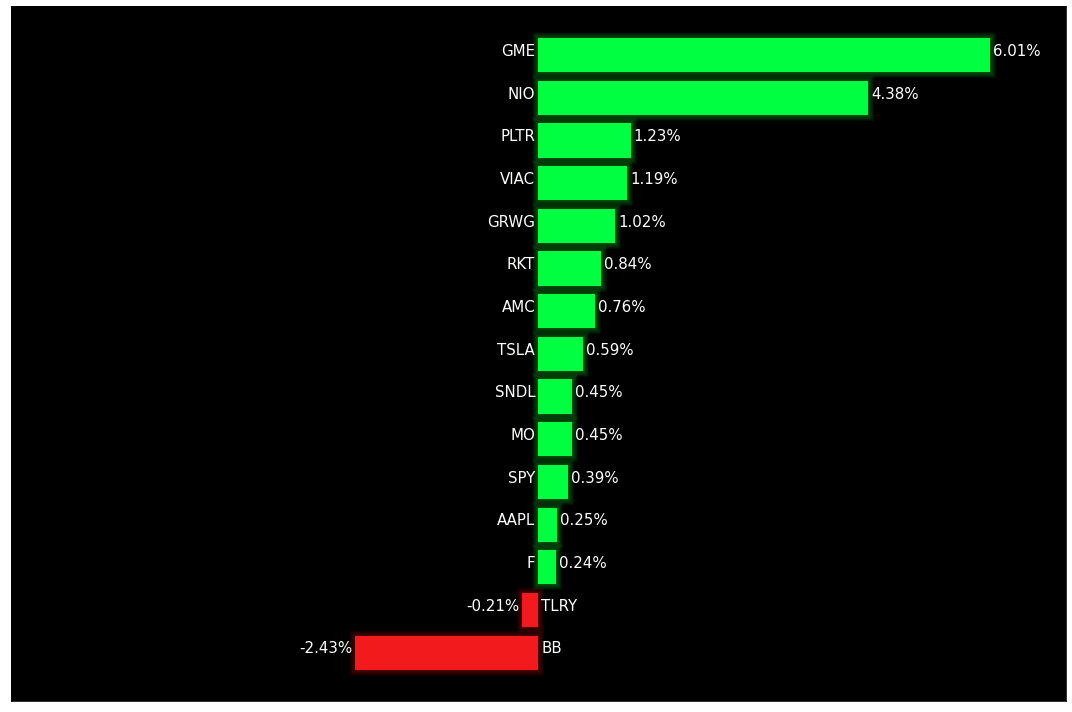

In [12]:
preds = pd.DataFrame({'Stock':stocks,'Change':predictions*100})
preds = preds.sort_values(by='Change',ascending=False,ignore_index=True)
dh.plotTodaysPrediction(preds,margin=1,text_margin=0.04,filename=prediction_plot_dir+today_formatted+'.png')

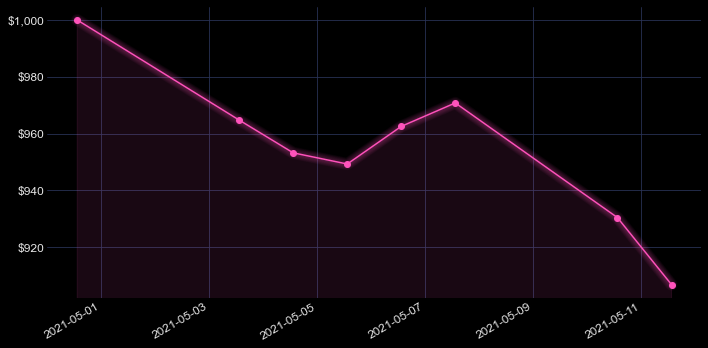

In [13]:
performance, up = trader.getPerformance()
dh.plotPerformance(performance, start='2021-04-30',up=up,filename=performance_plot_dir+today_formatted+'.png')

In [14]:
target = np.round(trader.weights * 906.91,2).reshape(-1)

In [15]:
target

array([199.54,  49.29,   7.39,   0.  ,  38.7 , 111.12,  25.01, 187.23,
        58.51,  15.77,  28.29,   1.89,   0.  ,  30.48, 153.68])

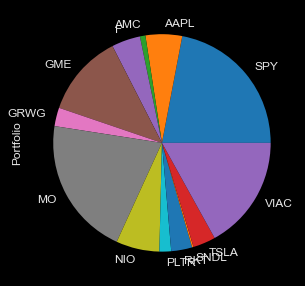

In [16]:
pie = pd.Series(target,
                  index=stocks)
plot = pie.plot.pie(figsize=(5, 5),label='Portfolio')

In [11]:
idx = 1
row = df.iloc[-1]
prices = row[price_cols].to_numpy()
buys = row[buy_cols].to_numpy()
predictions = row[pred_cols].to_numpy()